# **Computer Vision 2025 Assignment 3: Deep Learning for Perception Tasks**

This assignment contains 2 questions. The first question probes understanding of deep learning for classification. The second question requires you to write a short description of a Computer Vision method. You wil need to submit two separate PDF files, one for each question.
<br/><br/>

## **Question 1: A Simple Classifier *(20 marks, 60%)***

For this exercise, we provide demo code showing how to train a network on a small dataset called Fashion-MNIST. Please run through the code *"tutorial-style"* to get a sense of what it is doing. Then use the code alongside lecture notes and other resources to understand how to use pytorch libraries to implement, train and use a neural network. For the Fashion-MNIST dataset the labels from 0-9 correspond to various clothing classes so you might find it convenient to **create a python list as follows:**

**class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']**

You will need to answer various questions about the system, how it operates, the results of experiments with it and make modifications to it yourself. You can change the training scheme and the network structure. Organise your own text and code cell to show the answer of each question below. **Detailed requirements:**

In [2]:
# For Numerical Operations & Handling Arrays/Matrices Efficiently
import numpy as np  

# For Creating Static, Animated, & Interactive Plots
import matplotlib.pyplot as plt  

# Provides Time-Related Functions, Useful for Measuring Execution Time or Delays
import time  

# Functional API for Common Operations like Activation Functions & Loss Calculations
import torch.nn.functional as F

# Tools for Controlling Output Display in Jupyter Notebooks
from IPython import display  

# Import Code Book with Custom Function Definitions
from a3code import *

# Some Notebook Magic for Displaying Figures
%matplotlib inline

# Some More Magic For Reloading External Python Modules
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

<br/>

### **Q1.1 *(1 Point)***

Extract 3 images of different types of clothing from the training dataset, print out the size/shape of the training images, and display the three with their corresponding labels.

In [3]:
# Download Training Data from TorchVision's Open FashionMNIST Dataset
training_data = datasets.FashionMNIST(
    root="Data",           # Directory to Store the Dataset
    train=True,            # Specifies this is the Training Set
    download=True,         # Downloads the Dataset if Not Already Present
    transform=ToTensor(),  # Converts Images to PyTorch Tensors & Normalises Pixel Values
)

# Download Test Data from the Same Dataset
test_data = datasets.FashionMNIST(
    root="Data",           # Directory to Store the Dataset
    train=False,           # Specifies this is the Test Set
    download=True,         # Downloads the Dataset if Not Already Present
    transform=ToTensor(),  # Converts Images to PyTorch Tensors
)

# Number of Samples Per Batch to Load During Training/Testing
batch_size = 64

# Create Data Loaders to Iterate Over the Dataset in Batches
train_dataloader = DataLoader(training_data, batch_size=batch_size)  # Loads Training Data in Batches
test_dataloader = DataLoader(test_data, batch_size=batch_size)       # Loads Test Data in Batches

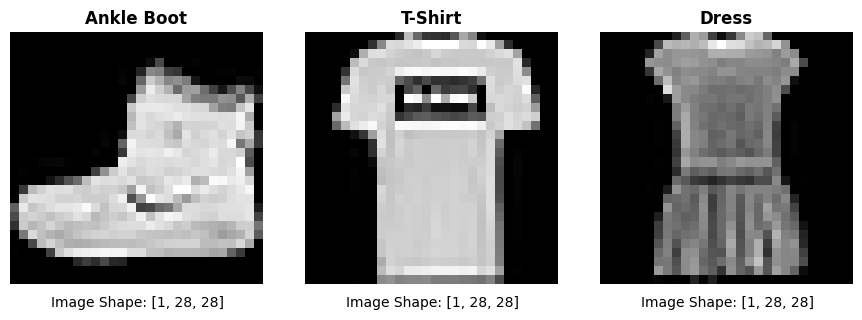

In [4]:
# Build a List of Class Names
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot"
}

# Display 3 Images from the Training Dataset
plt.figure(figsize=(9, 3))

# Find Three Unique Examples
unique_classes = {} # List for Storage
for img, label in training_data:

    # If it is New Add it to List
    if label not in unique_classes:
        unique_classes[label] = img

    # Stop Once there are 3 Examples
    if len(unique_classes) == 3:
        break


# Loop Through First 3 Images
for i, (label, image) in enumerate(unique_classes.items()):
    shape = f"Image Shape: {list(image.shape)}"
    label = labels_map[label]

    # Plot Image
    plt.subplot(1, 3, i+1)
    plt.imshow(image.squeeze(), cmap="gray")  # Squeeze() Removes Channel Dimension
    plt.title(f"{label}", fontweight="bold")
    plt.text(4, 30, f"{shape}", fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show() 

<br/>

### **Q1.2 *(2 Points)***

Run the training code for 10 epochs, for different values of the learning rate. **Fill in the table below and plot the loss curves for each experiment:**

|   LR    |Accuracy|
|   ---   |  ---   |
|  **1**  | 10.00% |
| **0.1** | 87.10% |
|**0.01** | 83.40% |
|**0.001**| 70.90% |

In [5]:
# Get CPU or GPU Device for Training
device = "cuda" if torch.cuda.is_available() else "cpu"

# Display which Device is Being Used
print("Using {} device".format(device))  

# Define a Simple Feedforward Neural Network Model
class NeuralNetwork(nn.Module):
    # Define the New Constructor
    def __init__(self):
        super(NeuralNetwork, self).__init__()  # Call the Constructor of nn.Module
        self.flatten = nn.Flatten()            # Flattens Input from (N, 1, 28, 28) to (N, 784)
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),  # First Fully Connected Layer (Input: 784 -> Output: 512)
            nn.ReLU(),              # ReLU Activation
            nn.Linear(512, 512),    # Second Fully Connected Layer
            nn.ReLU(),              # ReLU Activation
            nn.Linear(512, 10)      # Output Layer (10 Classes for FashionMNIST)
        )


    # Define the Forward Pass Function
    def forward(self, x):
        x = self.flatten(x)                  # Flatten the Input
        logits = self.linear_relu_stack(x)   # Pass Through the Linear & ReLU Stack
        return logits                        # Return Raw Scores (logits)

Using cpu device


In [ ]:
# Reset Model Weights and Parameters
model = NeuralNetwork().to(device)

# Train the Model for Learning Rate = 1
val_loss, _, _= train_model(model, train_dataloader, test_dataloader, epochs = 10, lr = 1)

Epoch 1
-------------------------------
loss: 2.304381  [    0/60000]
loss: 2.240117  [ 6400/60000]
loss: 1.853142  [12800/60000]
loss: 1.573513  [19200/60000]
loss: 1.506147  [25600/60000]
loss: 2.046149  [32000/60000]
loss: 1.881435  [38400/60000]
loss: 1.727267  [44800/60000]
loss: 1.659534  [51200/60000]
loss: 1.716035  [57600/60000]
Test Error: 
 Accuracy: 19.8%, Avg loss: 1.805322 

Epoch 2
-------------------------------
loss: 1.905846  [    0/60000]
loss: 1.685572  [ 6400/60000]
loss: 1.747570  [12800/60000]
loss: 1.679266  [19200/60000]
loss: 1.705224  [25600/60000]
loss: 1.775770  [32000/60000]
loss: 1.716686  [38400/60000]
loss: 1.712586  [44800/60000]
loss: 1.834286  [51200/60000]
loss: 1.694452  [57600/60000]
Test Error: 
 Accuracy: 19.9%, Avg loss: 1.770731 

Epoch 3
-------------------------------
loss: 1.853377  [    0/60000]
loss: 1.703413  [ 6400/60000]
loss: 2.311853  [12800/60000]
loss: 2.304621  [19200/60000]
loss: 2.281377  [25600/60000]
loss: 2.304950  [32000/600

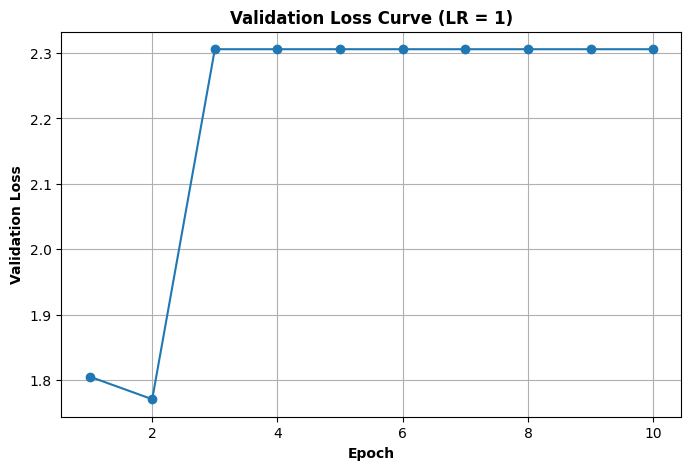

In [6]:
# Display the Loss Curve
display_loss("Validation Loss Curve (LR = 1)", "Epoch", "Validation Loss", val_loss, epochs = 10)

In [ ]:
# Reset Model Weights and Parameters
model = NeuralNetwork().to(device)

# Train the Model for Learning Rate = 0.1
val_loss, _, _ = train_model(model, train_dataloader, test_dataloader, epochs = 10, lr = 0.1)

Epoch 1
-------------------------------
loss: 2.300231  [    0/60000]
loss: 0.907546  [ 6400/60000]
loss: 0.574564  [12800/60000]
loss: 0.695282  [19200/60000]
loss: 0.622832  [25600/60000]
loss: 0.513278  [32000/60000]
loss: 0.553985  [38400/60000]
loss: 0.601808  [44800/60000]
loss: 0.610392  [51200/60000]
loss: 0.448075  [57600/60000]
Test Error: 
 Accuracy: 79.5%, Avg loss: 0.542811 

Epoch 2
-------------------------------
loss: 0.437911  [    0/60000]
loss: 0.444969  [ 6400/60000]
loss: 0.363449  [12800/60000]
loss: 0.440952  [19200/60000]
loss: 0.432802  [25600/60000]
loss: 0.448065  [32000/60000]
loss: 0.416971  [38400/60000]
loss: 0.509252  [44800/60000]
loss: 0.515141  [51200/60000]
loss: 0.420330  [57600/60000]
Test Error: 
 Accuracy: 82.6%, Avg loss: 0.468568 

Epoch 3
-------------------------------
loss: 0.337912  [    0/60000]
loss: 0.360573  [ 6400/60000]
loss: 0.296313  [12800/60000]
loss: 0.356336  [19200/60000]
loss: 0.355312  [25600/60000]
loss: 0.421528  [32000/600

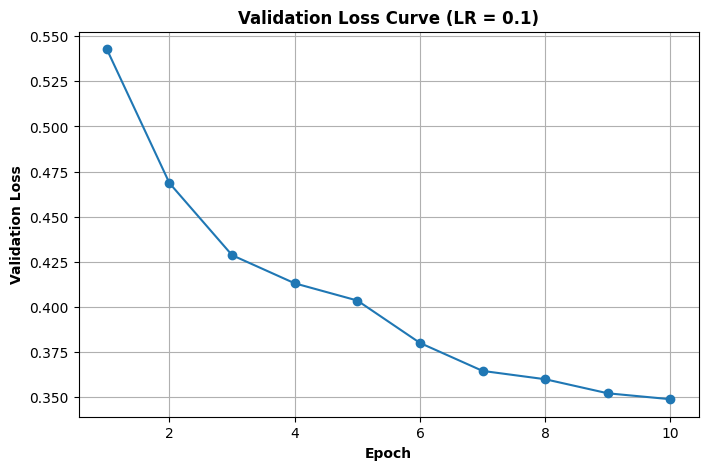

In [8]:
# Display the Loss Curve
display_loss("Validation Loss Curve (LR = 0.1)", "Epoch", "Validation Loss", val_loss, epochs = 10)

In [ ]:
# Reset Model Weights and Parameters
model = NeuralNetwork().to(device)

# Train the Model for Learning Rate = 0.01
val_loss, _, _ = train_model(model, train_dataloader, test_dataloader, epochs = 10, lr = 0.01)

Epoch 1
-------------------------------
loss: 2.307981  [    0/60000]
loss: 2.165900  [ 6400/60000]
loss: 1.807944  [12800/60000]
loss: 1.527438  [19200/60000]
loss: 1.155042  [25600/60000]
loss: 1.065181  [32000/60000]
loss: 1.008904  [38400/60000]
loss: 0.877814  [44800/60000]
loss: 0.877878  [51200/60000]
loss: 0.801108  [57600/60000]
Test Error: 
 Accuracy: 70.8%, Avg loss: 0.794447 

Epoch 2
-------------------------------
loss: 0.789444  [    0/60000]
loss: 0.848695  [ 6400/60000]
loss: 0.591558  [12800/60000]
loss: 0.780474  [19200/60000]
loss: 0.643451  [25600/60000]
loss: 0.653020  [32000/60000]
loss: 0.714013  [38400/60000]
loss: 0.697125  [44800/60000]
loss: 0.703661  [51200/60000]
loss: 0.628249  [57600/60000]
Test Error: 
 Accuracy: 77.8%, Avg loss: 0.632663 

Epoch 3
-------------------------------
loss: 0.562447  [    0/60000]
loss: 0.657781  [ 6400/60000]
loss: 0.442839  [12800/60000]
loss: 0.655745  [19200/60000]
loss: 0.558720  [25600/60000]
loss: 0.571697  [32000/600

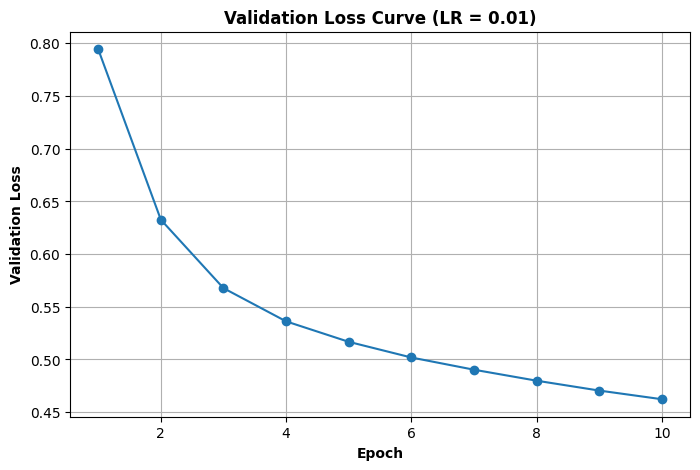

In [10]:
# Display the Loss Curve
display_loss("Validation Loss Curve (LR = 0.01)", "Epoch", "Validation Loss", val_loss, epochs = 10)

In [ ]:
# Reset Model Weights and Parameters
model = NeuralNetwork().to(device)

# Train the Model for Learning Rate = 0.001
val_loss, _, _ = train_model(model, train_dataloader, test_dataloader, epochs = 10, lr = 0.001)

Epoch 1
-------------------------------
loss: 2.300375  [    0/60000]
loss: 2.287667  [ 6400/60000]
loss: 2.261072  [12800/60000]
loss: 2.256611  [19200/60000]
loss: 2.230657  [25600/60000]
loss: 2.194524  [32000/60000]
loss: 2.218869  [38400/60000]
loss: 2.178834  [44800/60000]
loss: 2.170594  [51200/60000]
loss: 2.138046  [57600/60000]
Test Error: 
 Accuracy: 41.3%, Avg loss: 2.126739 

Epoch 2
-------------------------------
loss: 2.143348  [    0/60000]
loss: 2.125179  [ 6400/60000]
loss: 2.058338  [12800/60000]
loss: 2.075830  [19200/60000]
loss: 2.003081  [25600/60000]
loss: 1.941583  [32000/60000]
loss: 1.984028  [38400/60000]
loss: 1.896186  [44800/60000]
loss: 1.907362  [51200/60000]
loss: 1.828193  [57600/60000]
Test Error: 
 Accuracy: 53.8%, Avg loss: 1.817506 

Epoch 3
-------------------------------
loss: 1.868652  [    0/60000]
loss: 1.820734  [ 6400/60000]
loss: 1.697887  [12800/60000]
loss: 1.742244  [19200/60000]
loss: 1.623813  [25600/60000]
loss: 1.586347  [32000/600

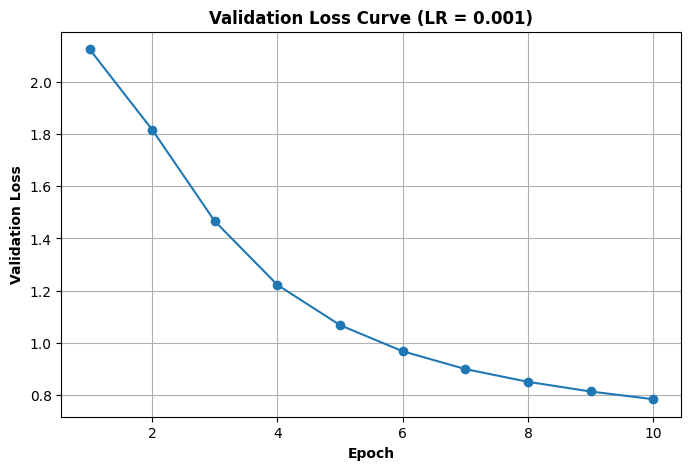

In [12]:
# Display the Loss Curve
display_loss("Validation Loss Curve (LR = 0.001)", "Epoch", "Validation Loss", val_loss, epochs = 10)

<br/>

### **Q1.3 *(3 Points)***

Report the number of epochs when the network converges *(or number of epochs for the best accuracy, if it fails to converge)*. Fill in the table below and plot the loss curve for each experiment. **Please run the code for more than 10 epochs *(e.g. 50 or 100)* and report when you observe convergence:**

|   LR    |Accuracy|Epoch|
|   ---   |   ---  | --- | 
|  **1**  |   NaN  | NaN |
| **0.1** | 88.50% | 15  |
|**0.01** | 88.10% | 59  |
|**0.001**| 84.60% | >100|

In [ ]:
# Reset Model Weights and Parameters
model = NeuralNetwork().to(device)

# Train the Model for Learning Rate = 1
val_loss, _, _ = train_model(model, train_dataloader, test_dataloader, epochs = 50, lr = 1)

Epoch 1
-------------------------------
loss: 2.300987  [    0/60000]
loss: 2.260561  [ 6400/60000]
loss: 4.276694  [12800/60000]
loss: 1.848274  [19200/60000]
loss: 1.541758  [25600/60000]
loss: 1.864596  [32000/60000]
loss: 1.698080  [38400/60000]
loss: 459.498291  [44800/60000]
loss:     nan  [51200/60000]
loss:     nan  [57600/60000]
Test Error: 
 Accuracy: 10.0%, Avg loss:      nan 

Epoch 2
-------------------------------
loss:     nan  [    0/60000]
loss:     nan  [ 6400/60000]
loss:     nan  [12800/60000]
loss:     nan  [19200/60000]
loss:     nan  [25600/60000]
loss:     nan  [32000/60000]
loss:     nan  [38400/60000]
loss:     nan  [44800/60000]
loss:     nan  [51200/60000]
loss:     nan  [57600/60000]
Test Error: 
 Accuracy: 10.0%, Avg loss:      nan 

Epoch 3
-------------------------------
loss:     nan  [    0/60000]
loss:     nan  [ 6400/60000]
loss:     nan  [12800/60000]
loss:     nan  [19200/60000]
loss:     nan  [25600/60000]
loss:     nan  [32000/60000]
loss:     na

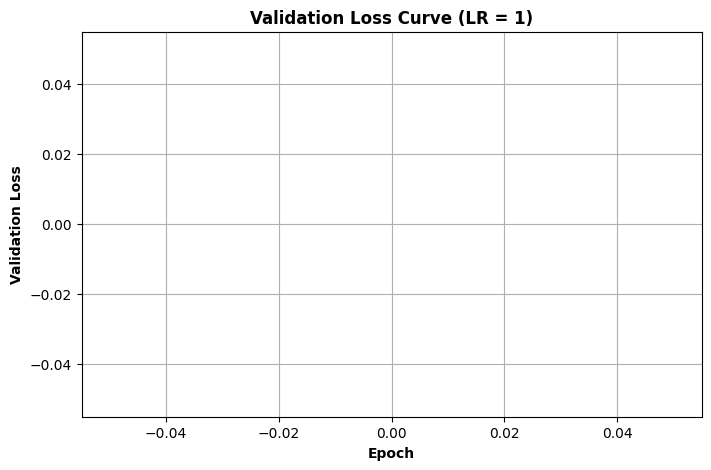

In [ ]:
# Display the Loss Curve
display_loss("Validation Loss Curve (LR = 1)", "Epoch", "Validation Loss", val_loss, epochs = 50)

In [ ]:
# Reset Model Weights and Parameters
model = NeuralNetwork().to(device)

# Train the Model for Learning Rate = 0.1
val_loss, _, _ = train_model(model, train_dataloader, test_dataloader, epochs = 50, lr = 0.1)

Epoch 1
-------------------------------
loss: 2.298384  [    0/60000]
loss: 0.903054  [ 6400/60000]
loss: 0.578937  [12800/60000]
loss: 0.720504  [19200/60000]
loss: 0.625815  [25600/60000]
loss: 0.509764  [32000/60000]
loss: 0.535653  [38400/60000]
loss: 0.596005  [44800/60000]
loss: 0.610022  [51200/60000]
loss: 0.460389  [57600/60000]
Test Error: 
 Accuracy: 78.8%, Avg loss: 0.554161 

Epoch 2
-------------------------------
loss: 0.430804  [    0/60000]
loss: 0.449234  [ 6400/60000]
loss: 0.394361  [12800/60000]
loss: 0.443136  [19200/60000]
loss: 0.407269  [25600/60000]
loss: 0.450118  [32000/60000]
loss: 0.414715  [38400/60000]
loss: 0.515605  [44800/60000]
loss: 0.510657  [51200/60000]
loss: 0.430827  [57600/60000]
Test Error: 
 Accuracy: 82.4%, Avg loss: 0.469457 

Epoch 3
-------------------------------
loss: 0.318184  [    0/60000]
loss: 0.362796  [ 6400/60000]
loss: 0.317775  [12800/60000]
loss: 0.369320  [19200/60000]
loss: 0.336473  [25600/60000]
loss: 0.423328  [32000/600

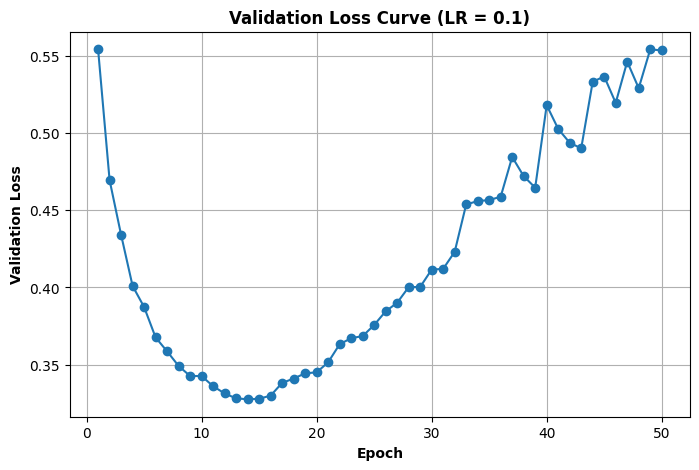

In [23]:
# Display the Loss Curve
display_loss("Validation Loss Curve (LR = 0.1)", "Epoch", "Validation Loss", val_loss, epochs = 50)

In [ ]:
# Reset Model Weights and Parameters
model = NeuralNetwork().to(device)

# Train the Model for Learning Rate = 0.01
val_loss, _, _ = train_model(model, train_dataloader, test_dataloader, epochs = 100, lr = 0.01)

Epoch 1
-------------------------------
loss: 2.308052  [    0/60000]
loss: 2.167721  [ 6400/60000]
loss: 1.809226  [12800/60000]
loss: 1.497797  [19200/60000]
loss: 1.149712  [25600/60000]
loss: 1.056108  [32000/60000]
loss: 1.008190  [38400/60000]
loss: 0.880538  [44800/60000]
loss: 0.877277  [51200/60000]
loss: 0.810130  [57600/60000]
Test Error: 
 Accuracy: 71.7%, Avg loss: 0.792567 

Epoch 2
-------------------------------
loss: 0.788404  [    0/60000]
loss: 0.845593  [ 6400/60000]
loss: 0.588665  [12800/60000]
loss: 0.781097  [19200/60000]
loss: 0.656730  [25600/60000]
loss: 0.643947  [32000/60000]
loss: 0.713495  [38400/60000]
loss: 0.700723  [44800/60000]
loss: 0.710678  [51200/60000]
loss: 0.641399  [57600/60000]
Test Error: 
 Accuracy: 77.7%, Avg loss: 0.635842 

Epoch 3
-------------------------------
loss: 0.566706  [    0/60000]
loss: 0.663837  [ 6400/60000]
loss: 0.444263  [12800/60000]
loss: 0.667429  [19200/60000]
loss: 0.578144  [25600/60000]
loss: 0.567844  [32000/600

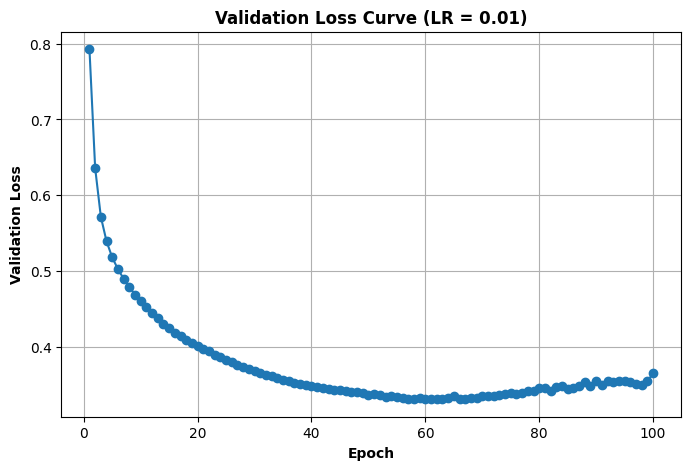

In [25]:
# Display the Loss Curve
display_loss("Validation Loss Curve (LR = 0.01)", "Epoch", "Validation Loss", val_loss, epochs = 100)

In [ ]:
# Reset Model Weights and Parameters
model = NeuralNetwork().to(device)

# Train the Model for Learning Rate = 0.001
val_loss, _, _ = train_model(model, train_dataloader, test_dataloader, epochs = 100, lr = 0.001)

Epoch 1
-------------------------------
loss: 2.316695  [    0/60000]
loss: 2.302773  [ 6400/60000]
loss: 2.280898  [12800/60000]
loss: 2.269434  [19200/60000]
loss: 2.249765  [25600/60000]
loss: 2.230812  [32000/60000]
loss: 2.229759  [38400/60000]
loss: 2.207782  [44800/60000]
loss: 2.212696  [51200/60000]
loss: 2.165657  [57600/60000]
Test Error: 
 Accuracy: 44.7%, Avg loss: 2.166022 

Epoch 2
-------------------------------
loss: 2.186348  [    0/60000]
loss: 2.174058  [ 6400/60000]
loss: 2.118724  [12800/60000]
loss: 2.131742  [19200/60000]
loss: 2.081029  [25600/60000]
loss: 2.032972  [32000/60000]
loss: 2.051937  [38400/60000]
loss: 1.985441  [44800/60000]
loss: 1.995420  [51200/60000]
loss: 1.914982  [57600/60000]
Test Error: 
 Accuracy: 56.1%, Avg loss: 1.915220 

Epoch 3
-------------------------------
loss: 1.950727  [    0/60000]
loss: 1.920579  [ 6400/60000]
loss: 1.807307  [12800/60000]
loss: 1.847536  [19200/60000]
loss: 1.733848  [25600/60000]
loss: 1.687310  [32000/600

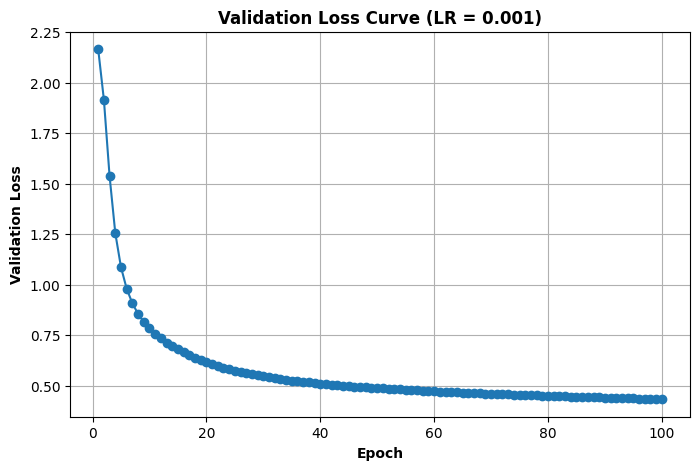

In [27]:
# Display the Loss Curve
display_loss("Validation Loss Curve (LR = 0.001)", "Epoch", "Validation Loss", val_loss, epochs = 100)

<br/>

### **Q1.4 *(2 Points)***

**Compare the results in table 1 and table 2, what is your observation and your understanding of learning rate?**
<br/>

Upon examining the results from Tables 1 and 2, a few key observations can be made about the effect of the learning rate on training and convergence. A learning rate of 1 is quite large, resulting in erratic and unstable updates during training. In the first few epochs, the accuracy fluctuates drastically, which may result in NaN *(Not a Number)* values in the loss, indicating a failure to maintain stability during training. This phenomenon occurs due to exploding gradients, where large weight updates cause the model to overshoot and fail to converge. Additionally, the learning rate of 0.1 produces the highest accuracy *(87.10%)* within the first 10 epochs, as shown in Table 1. This value strikes a balance between large enough updates to quickly reduce loss, but not so large that it overshoots optimal points. The model converges to the best accuracy *(88.50%)* in approximately 15 epochs, as confirmed in Table 2. This learning rate is ideal for quick yet stable convergence, which is why the accuracy is higher compared to smaller learning rates.


With a learning rate of 0.01, the model requires more time to converge, as it makes smaller, more stable updates. While this rate leads to a slightly lower accuracy *(83.40%)* in 10 epochs, it performs approximately the same as the 0.1 learning rate with extended training *(59 epochs)*. However, the model still takes longer to converge compared to 0.1, suggesting that small learning rates can lead to slow progress but a more refined convergence over time. This is evident in the smooth gradient of the loss curve. Finally, a learning rate of 0.001 is very small and results in slow convergence. The model’s accuracy remains low in the first 10 epochs *(70.90%)* and takes over 100 epochs to completely converge, achieving an accuracy of around 84.60% after 100 epochs. While this rate offers stability, it also illustrates that extremely slow updates may not allow the model to reach its potential within a reasonable amount of time. 


Overall, comparing the results in Table 1 and Table 2, it is clear that the learning rate has a significant impact on both training stability and convergence speed. A learning rate of 1 is too high, causing unstable updates and divergence due to exploding gradients, often resulting in NaN losses. In contrast, a very low learning rate like 0.001 ensures stability but requires far more epochs to converge, leading to lower accuracy within a limited training window. The optimal performance in this experiment was achieved with a learning rate of 0.1, which balanced convergence speed and training stability, reaching a maximum accuracy of around 88% in just 15 epochs. This suggests that 0.1 is well-tuned for the current model and dataset. However, the observed accuracy plateau also indicates a possible limitation of the model’s capacity. Future improvements could involve modifying the network architecture, such as adjusting the number of hidden layers or neurons, to better capture complex data patterns and potentially exceed the current performance ceiling. Ultimately, this experiment highlights the importance of selecting an appropriate learning rate, as it directly influences not just how fast a model learns, but whether it learns at all.

---

<br/>

### **Q1.5 *(5 Points)***

Build a wider network by modifying the code that constructs the network so that the hidden layer(s) contain more perceptrons, and record the accuracy along with the number of trainable parameters in your model.  Now modify the original network to be deeper instead of wider *(**i.e.** by adding more hidden layers)*. Record your accuracy and network size findings. Plot the loss curve for each experiment. Also plot the test accuracy and loss for both the wider and deeper architectures and discuss what you observe. **Write down your conclusions about changing the network structure.**

|Structures|Accuracy|Parameters|
|   ---    |   ---  |    ---   |
| **Base** | 88.30% | 669,706  |
|**Deeper**| 87.80% | 830,090  |
|**Wider** | 88.20% |1,863,690 |

In [ ]:
# Get CPU or GPU Device for Training
device = "cuda" if torch.cuda.is_available() else "cpu"

# Display which Device is Being Used
print("Using {} device".format(device))  

# Use Simple Model From Parts Above
model = NeuralNetwork().to(device)

# Count Trainable Parameters
print(f"Trainable parameters: {count_trainable_params(model)}")

# Train the Model for Learning Rate = 0.1
val_loss, val_accuracy, grad_loss_base = train_model(model, train_dataloader, test_dataloader, epochs = 15, lr = 0.1)

Using cpu device
Trainable parameters: 669706
Epoch 1
-------------------------------
loss: 2.298212  [    0/60000]
loss: 0.907029  [ 6400/60000]
loss: 0.586957  [12800/60000]
loss: 0.709988  [19200/60000]
loss: 0.608467  [25600/60000]
loss: 0.505389  [32000/60000]
loss: 0.544532  [38400/60000]
loss: 0.587893  [44800/60000]
loss: 0.604707  [51200/60000]
loss: 0.449162  [57600/60000]
Test Error: 
 Accuracy: 79.4%, Avg loss: 0.545221 

Epoch 2
-------------------------------
loss: 0.432456  [    0/60000]
loss: 0.431793  [ 6400/60000]
loss: 0.380810  [12800/60000]
loss: 0.435946  [19200/60000]
loss: 0.417363  [25600/60000]
loss: 0.452296  [32000/60000]
loss: 0.410084  [38400/60000]
loss: 0.498929  [44800/60000]
loss: 0.519539  [51200/60000]
loss: 0.414574  [57600/60000]
Test Error: 
 Accuracy: 81.7%, Avg loss: 0.480436 

Epoch 3
-------------------------------
loss: 0.347718  [    0/60000]
loss: 0.364724  [ 6400/60000]
loss: 0.311041  [12800/60000]
loss: 0.359781  [19200/60000]
loss: 0.35

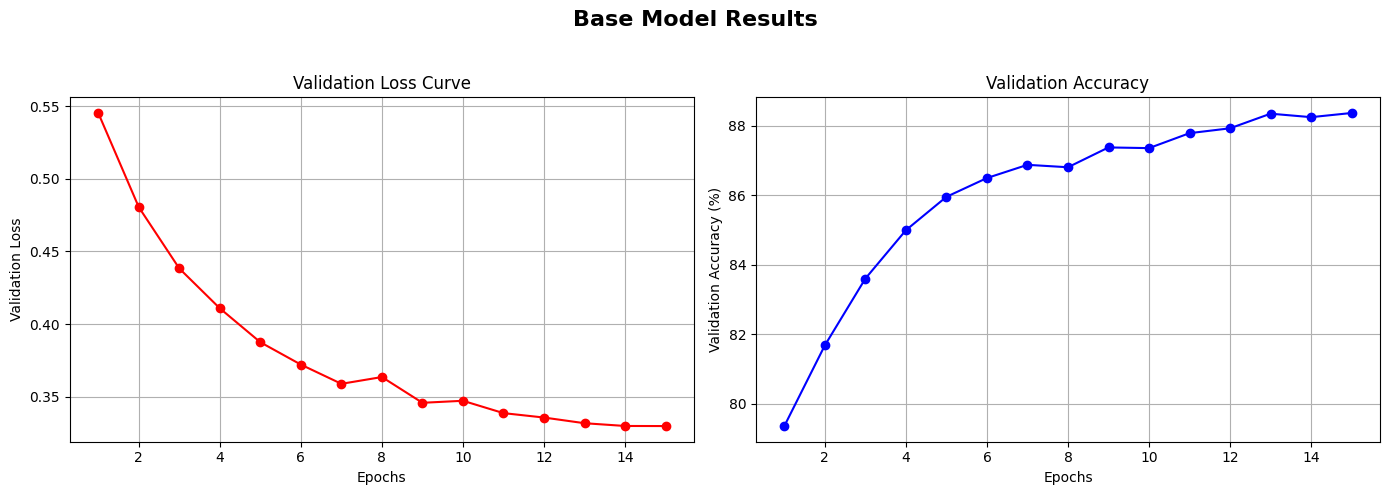

In [24]:
# Display the Loss Curve
display_loss_accuracy("Base Model Results", val_loss, val_accuracy, epochs=15)

In [ ]:
# Define a Wider Model
class WideNeuralNetwork(nn.Module):
    def __init__(self):
        super(WideNeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 1024),  # Wider layer
            nn.ReLU(),
            nn.Linear(1024, 1024),   # Another Wider Layer
            nn.ReLU(),
            nn.Linear(1024, 10)      # Output Layer
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
# Get CPU or GPU Device for Training
device = "cuda" if torch.cuda.is_available() else "cpu"

# Display which Device is Being Used
print("Using {} device".format(device))  

# Use the New Model Above
model = WideNeuralNetwork().to(device)

# Count Trainable Parameters
print(f"Trainable parameters: {count_trainable_params(model)}")

# Train the Model for Learning Rate = 0.1
val_loss, val_accuracy, grad_loss_wide = train_model(model, train_dataloader, test_dataloader, epochs = 15, lr = 0.1)

Using cpu device
Trainable parameters: 1863690
Epoch 1
-------------------------------
loss: 2.310155  [    0/60000]
loss: 0.863205  [ 6400/60000]
loss: 0.555831  [12800/60000]
loss: 0.687667  [19200/60000]
loss: 0.611422  [25600/60000]
loss: 0.497284  [32000/60000]
loss: 0.534272  [38400/60000]
loss: 0.583293  [44800/60000]
loss: 0.597288  [51200/60000]
loss: 0.459333  [57600/60000]
Test Error: 
 Accuracy: 79.7%, Avg loss: 0.537182 

Epoch 2
-------------------------------
loss: 0.417114  [    0/60000]
loss: 0.415555  [ 6400/60000]
loss: 0.371366  [12800/60000]
loss: 0.427778  [19200/60000]
loss: 0.402028  [25600/60000]
loss: 0.449555  [32000/60000]
loss: 0.407617  [38400/60000]
loss: 0.487870  [44800/60000]
loss: 0.501166  [51200/60000]
loss: 0.423790  [57600/60000]
Test Error: 
 Accuracy: 82.9%, Avg loss: 0.460535 

Epoch 3
-------------------------------
loss: 0.321901  [    0/60000]
loss: 0.339385  [ 6400/60000]
loss: 0.308018  [12800/60000]
loss: 0.358520  [19200/60000]
loss: 0.3

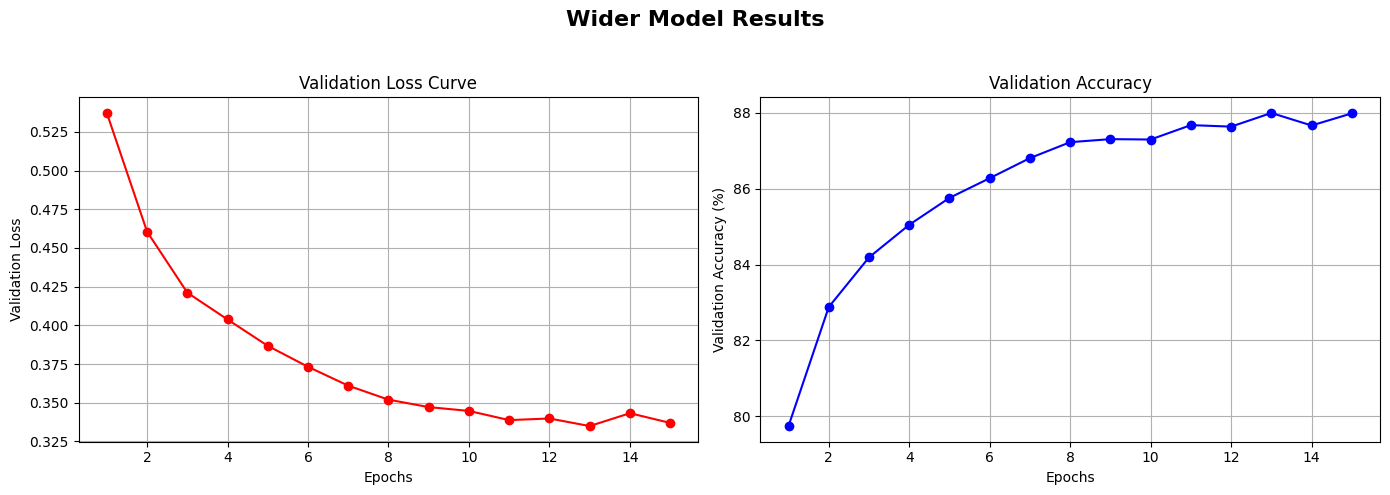

In [26]:
# Display the Loss Curve
display_loss_accuracy("Wider Model Results", val_loss, val_accuracy, epochs=15)

In [27]:
# Define a Deeper Model
class DeeperNeuralNetwork(nn.Module):
    def __init__(self):
        super(DeeperNeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 256),  # New Hidden Layer
            nn.ReLU(),
            nn.Linear(256, 128),  # New Hidden Layer
            nn.ReLU(),
            nn.Linear(128, 10)    # Output Layer
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# Get CPU or GPU Device for Training
device = "cuda" if torch.cuda.is_available() else "cpu"

# Display which Device is Being Used
print("Using {} device".format(device))  

# Use the New Model Above
model = DeeperNeuralNetwork().to(device)

# Count Trainable Parameters
print(f"Trainable parameters: {count_trainable_params(model)}")

# Train the Model for Learning Rate = 0.1
val_loss, val_accuracy, grad_loss_deep = train_model(model, train_dataloader, test_dataloader, epochs = 15, lr = 0.1)

Using cpu device
Trainable parameters: 830090
Epoch 1
-------------------------------
loss: 2.312882  [    0/60000]
loss: 1.625096  [ 6400/60000]
loss: 0.923785  [12800/60000]
loss: 0.824534  [19200/60000]
loss: 0.604959  [25600/60000]
loss: 0.495460  [32000/60000]
loss: 0.559091  [38400/60000]
loss: 0.624385  [44800/60000]
loss: 0.613680  [51200/60000]
loss: 0.513180  [57600/60000]
Test Error: 
 Accuracy: 79.6%, Avg loss: 0.549659 

Epoch 2
-------------------------------
loss: 0.451720  [    0/60000]
loss: 0.461503  [ 6400/60000]
loss: 0.439801  [12800/60000]
loss: 0.513125  [19200/60000]
loss: 0.435334  [25600/60000]
loss: 0.459830  [32000/60000]
loss: 0.412974  [38400/60000]
loss: 0.519979  [44800/60000]
loss: 0.507588  [51200/60000]
loss: 0.447758  [57600/60000]
Test Error: 
 Accuracy: 81.1%, Avg loss: 0.501694 

Epoch 3
-------------------------------
loss: 0.353320  [    0/60000]
loss: 0.363977  [ 6400/60000]
loss: 0.405457  [12800/60000]
loss: 0.370695  [19200/60000]
loss: 0.36

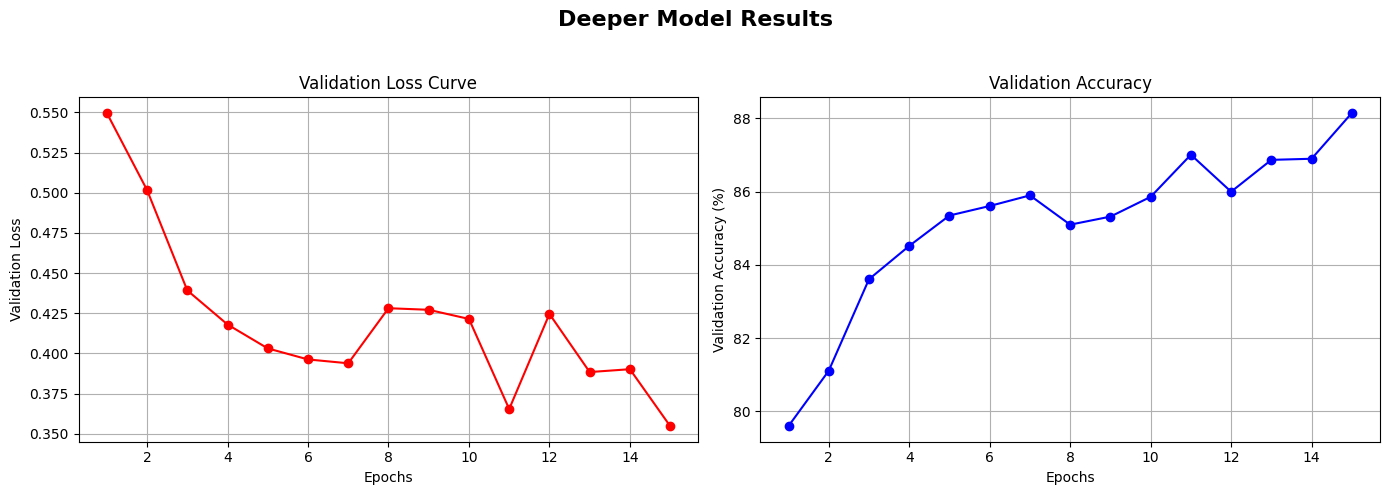

In [28]:
# Display the Loss Curve
display_loss_accuracy("Deeper Model Results", val_loss, val_accuracy, epochs=15)

The base model employed in this experiment uses a standard fully connected architecture with two hidden layers of 512 neurons each, achieving a strong test accuracy of 88.30%. The learning rate was set to 0.1, and the model was trained over 15 epochs. These hyperparameters were chosen based on their ability to provide fast and stable convergence on the relatively simple FashionMNIST dataset, as seen in the discussion above. With 669,706 trainable parameters, the base model strikes a healthy balance between model complexity and performance. The validation curves for both loss and accuracy demonstrated reasonably smooth convergence, indicating effective learning.


To explore the impact of model width, the number of neurons in each hidden layer was doubled to 1024, significantly increasing the trainable parameters to 1,863,690. Despite the larger capacity, the test accuracy remained nearly unchanged at 88.20%. However, the wider model displayed smoother training dynamics. This is evident in the loss decreasing more steadily, and the accuracy increasing with less fluctuation compared to the base model. This suggests that the wider network facilitated better gradient flow and optimisation stability. Nevertheless, the lack of improvement in test accuracy suggests that the base model already possessed sufficient capacity to capture the patterns in the dataset. As such, the additional parameters did not contribute to better generalisation, likely due to a performance ceiling on the FashionMNIST dataset.


In contrast, the deeper model introduced two additional hidden layers, resulting in a total of five fully connected layers with 512 neurons each. This increased the parameter count to 830,090, which is more than the base model but still less than the wider one. Surprisingly, this configuration led to a slightly lower test accuracy of 87.80%. The loss curve showed sharper fluctuations, and the accuracy curve was more erratic, indicating less stable convergence during validation. Deeper networks can suffer from issues such as vanishing gradients and optimisation difficulties, particularly when not paired with architectural enhancements like batch normalisation or residual connections. In this case, the added depth may have made it harder for the model to learn effectively, resulting in higher loss and marginally worse performance.


Overall, the experiments above demonstrate that widening the network can improve the training behaviour, but does not enhance generalisation, while deepening the network makes training more unstable and can result in degraded performance. These results suggest that for datasets like FashionMNIST, where the classification task is relatively straightforward, increasing model complexity beyond a certain point provides diminishing returns. 

---

<br/>

### **Q1.6 *(2 Points)***

Calculate the mean of the gradients of the loss to all trainable parameters. Plot the gradients curve for the first 100 training steps. What are your observations? Note that this gradients will be saved with the training weight automatically after you call loss.backwards(). **Hint:** The mean of the gradients decrease.

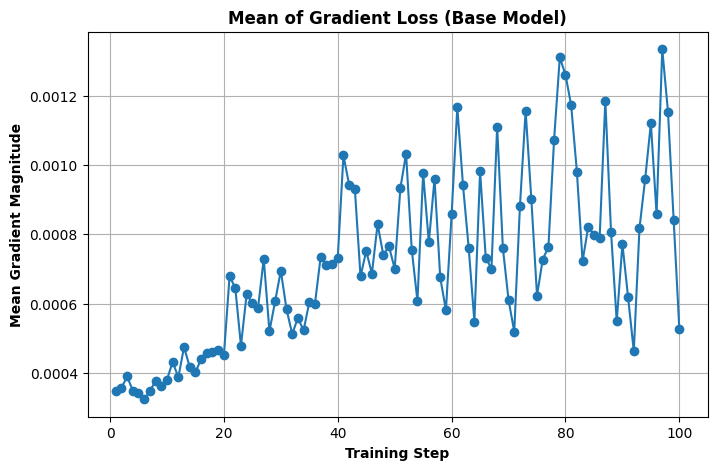

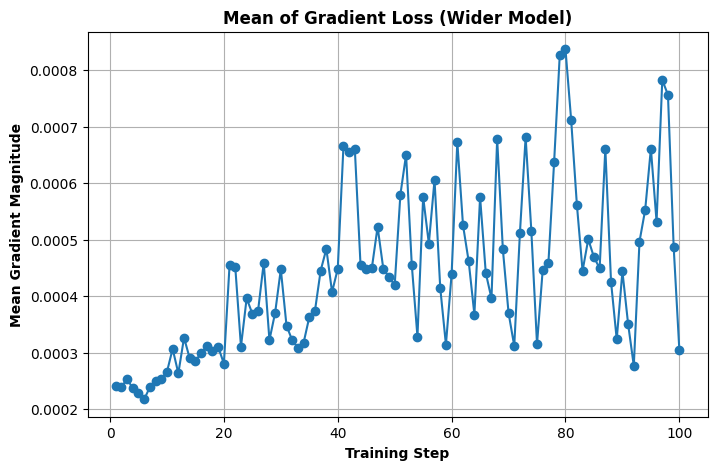

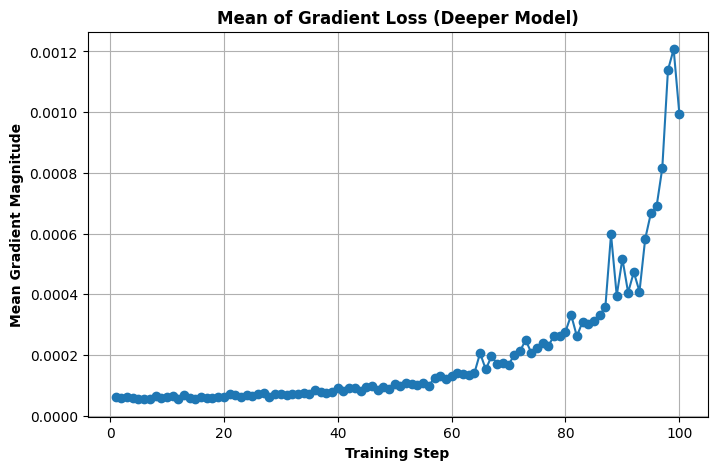

In [29]:
# Dispaly Gradient Loss for Base Model
display_loss("Mean of Gradient Loss (Base Model)", "Training Step", "Mean Gradient Magnitude", grad_loss_base[0], epochs = 100)

# Dispaly Gradient Loss for Wider Model
display_loss("Mean of Gradient Loss (Wider Model)", "Training Step", "Mean Gradient Magnitude", grad_loss_wide[0], epochs = 100)

# Dispaly Gradient Loss for Deeper Model
display_loss("Mean of Gradient Loss (Deeper Model)", "Training Step", "Mean Gradient Magnitude", grad_loss_deep[0], epochs = 100)

After calculating and displaying the mean of the gradient of the loss with respect to all trainable parameters, several interesting trends across the different model architectures emerge. Firstly, since the loss is only calculated over the first 100 training steps, the mean gradients tend to increase rather than decrease, which is somewhat counterintuitive. This happens because, early in training, the model parameters are still close to their initial random values and haven’t yet adjusted to minimise the loss. Without extended training, the model doesn't converge, and gradient magnitudes can grow as the model begins to push weights in different directions to try and build the network’s learning signal.


For the base model *(the smallest in terms of parameter count)*, the gradient behaviour is quite erratic, showing significant oscillations between approximately 0.0003 and 0.0012. This is likely because the smaller model has limited capacity to represent complex functions, so each weight update has a larger relative effect on the model's output. This leads to more volatility in gradients as the model attempts to adjust. In contrast, the wider model, which features more neurons per layer, also shows some erratic behaviour but within a tighter range *(0.0002–0.0008)*. This may be due to the increased redundancy and expressiveness of a wider network, which spreads the learning signal more evenly across more parameters. As a result, individual gradients are generally smaller and less volatile.


Finally, the deeper model, with two additional hidden layers, starts with very low gradient values *(~0.0001)* and shows a steadier, almost exponential increase up to about 0.0012. This behaviour can be attributed to the gradient flow across many layers, where initially, due to poor signal propagation *(possibly from vanishing gradients)*, updates are small. As training progresses, the deeper architecture begins to amplify gradients slightly as the model starts learning more abstract features layer by layer, especially if activation functions and weight initialisation are well-chosen. Overall, it is observed above that model architecture significantly affects gradient dynamics during early training. Smaller models exhibit more unstable gradients, while deeper models show more structured evolution, and wider models benefit from smoother learning signals due to their greater capacity and redundancy.

---

<br/>

### **Q1.7 *(5 Points)***

Modify the network structure and training/test to use a small convolutional neural network instead of an MLP. Discuss your findings with regard to convergence, accuracy and number of parameters, relative to MLPs. **Hint:** Look at the structure of the CNN in the Workshop 3 examples.

For more explanation of q1.7, you could refer to the following simple instructions: https://colab.research.google.com/drive/1XAsyNegGSvMf3_B6MrsXht7-fHqtJ7OW?usp=sharing.

In [30]:
# Insert Code Here

***Add Discussion Notes Here***

- Discuss your findings with regard to convergence, accuracy and number of parameters, relative to MLPs.

---

<br/><br/>


# **Question 2: Optional Bonus Question  *(5 Marks, 20% Bonus Marks)***
<br/>

### **Q2.1 *(2 Points)***

Experiment with different activation functions (ReLU, Tanh, Sigmoid) and analyse their impact on training performance.

In [31]:
# Insert Code Here

***Add Discussion Notes Here***

---

<br/>

### **Q2.2 *(1 Point)***

In particular, focus your analysis on the Sigmoid activation function and discuss your finding of training with and without Xavier initialisation. You may use the provided code for Xavier initialisation for this.

In [32]:
# Now We Will Apply Xavier Initialisation to the Model
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# Lets Apply the Xavier Initialisation to the Model
model.apply(init_weights)

# Now We Will Train & Test the Model Again with the Xavier Initialisation
epochs = 5

# Training & Testing Loop
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

# Insert Code Here

Epoch 1
-------------------------------


NameError: name 'loss_fn' is not defined

***Add Discussion Notes Here***

---

<br/>

### **Q2.3 *(1 Point)***

Additionally, plot both the gradient and loss curves for your experiments. For gradient analysis, you may select one representative layer to monitor throughout training and briefly explain your choice.

In [ ]:
# Insert Code Here

***Add Discussion Notes Here***

---

<br/>

### **Q2.4 *(1 Point)***

**Discuss how gradients and loss behave across the network for different activation functions and initialisation methods if you see any difference.**

***Add Discussion Notes Here***

---

<br/><br/>
## **Question 3: Proposal for Practical Applications *(40%)***

In this part of the assignment you need to write a report about an application of a computer vision algorithm or technique. This can either be an application that you are aware of and possibly even use, such as a phone app, or it could be speculation -- an application that you think would benefit from using computer vision.

**Begin by choosing a particular CV idea, method or problem area, such as:**

**a.** Removing noise in an image.

**b.** Increasing the resolution of an image.

**c.** Detecting and/or identifying objects in an image.

**d.** Segmenting images into constituents parts.

**e.** Estimating the depth of an object from one or more images.

**f.** Estimating the motion of two objects in different frames.

**g.** Others
<br/><br/>


Now think about various ways your chosen technique could be used. Here is a list of possible applications you could consider, but you are not restricted to this list, and there will be credit given for sensible invention outside this list (but no penalty if you don't want to be "inventive"): image editing systems in your phone; enhancement of images from old film; obstacle detection and avoidance for a domestic robot; facial recognition for phone security; cancer detection; person tracking and re-identification in security cameras; sport decision review systems; road-sign detection and interpretation for self-driving cars.
<br/>

This is a little bit back-to-front from what might happen in real life in which the application usually motivates the solution, but the emphasis here is on an understanding of the CV technique.
<br/><br/>


**You need to write a short report *(800 words max)* in which you do the following:**

**1.** Clearly define the CV problem/area and describe its application scenarios.

**2.** Briefly describe a solution based on image processing, computer vision and/or machine learning.

**3.** Discuss the advantages and the limitations of this method in various application scenarios.

**4.** It is important that you will define a useful metric to evaluate the performance of your method and discuss its tradeoff specific to the problem you have chosen.

**5.** You are welcome to cite existing work and take inspiration form literature addressing the problem you choose.
<br/><br/>


**For Q3, you do not need to implement your solution. Just write the proposal/report and submit it as a separate PDF.**

- **Hint 1:** Submit an individual pdf report for question 3.

- **Hint 2:** Organise your report well.

- **Hint 3:** You can use diagrams, flow charts or other figures in your report for better understanding of your solution.  

